In [61]:
%matplotlib notebook
#%matplotlib inline
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from env.fetch_reach_mod import FetchReachMod

Experiments with the FetchReach environment (see eval_results_nearbystates.ipynb also). Here we look at conditioning on both a goal and the current state, to predict a plausible state within $\tau$ steps of the goal.

# Experiment 1: WGAN with spectral normalisation only + skipconns

In [6]:
loss_record_1 = joblib.load("results/goal_cond/SNonly_skipconns/losses.pkl")

In [7]:
loss_record_1.keys()

dict_keys(['big_eval_avg_distance', 'avg_distance', 'std_distance_empirical', 'D', 'big_eval_std_distance', 'std_distance', 'avg_distance_empirical', 'G'])

Note: here average distance is measured from the goal state to the generated state, rather than the other way round

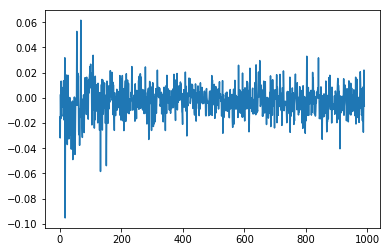

In [8]:
plt.plot(loss_record_1["D"][::1000])

looks sensible

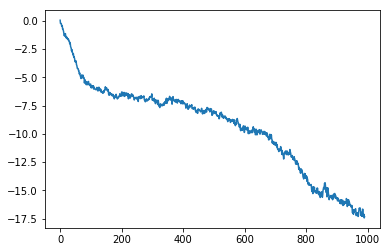

In [6]:
plt.plot(loss_record_1["G"][::200])

(0.3, 0.6)

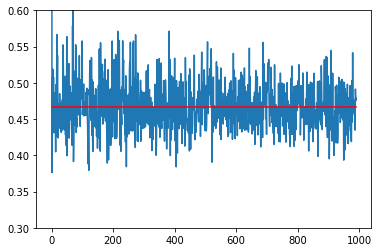

In [8]:
plt.plot(loss_record_1["avg_distance"][::1000])
plt.plot([loss_record_1["avg_distance_empirical"] for _ in range(len(loss_record_1["avg_distance"][::1000]))], c="red")
plt.ylim([0.3,0.6])

actually a little bit noisy - but clearly centred around the empirical value (and we're not using "big eval" here, so evaluating on smaller batches - noise is to be expected!)

In [10]:
loss_record_1["big_eval_avg_distance"] #forgot to append...

0.44787362217903137

(0.1, 0.3)

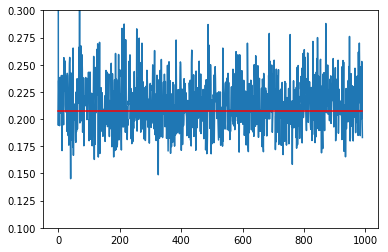

In [11]:
plt.plot(loss_record_1["std_distance"][::1000])
plt.plot([loss_record_1["std_distance_empirical"] for _ in range(len(loss_record_1["std_distance"][::1000]))], c="red")
plt.ylim([0.1,0.3])

### Visualisation

In [64]:
from networks.networks import Generator, Discriminator, Generator_alt, Discriminator_alt
data = joblib.load("data_nearby_states.pkl")
state_dim = 3; num_trajs = 10000; traj_length=100;
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, state_dim)).reshape(num_trajs, traj_length, state_dim)

latent_dim = 64
tau = 5

device = "cuda"
netG_1 = Generator_alt(state_dim, latent_dim, state_dim, batch_norm=True, hidden_sizes=[128, 256, 512], goal_dim=state_dim, cond_on_goal=True).to(device)
dict_G, dict_D = joblib.load("results/goal_cond/SNonly_skipconns/parameters.pkl")
netG_1.load_state_dict(dict_G)
netG_1.eval()

Generator_alt(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=70, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=134, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=262, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (out_layer): Linear(in_features=518, out_features=3, bias=True)
)

In [65]:
def sample_batch(size):
    traj_ind = np.random.randint(0, num_trajs, size)
    state_ind = np.random.randint(0, traj_length-2*tau, size)
    goal_ind = (state_ind + tau + np.round(np.random.random(state_ind.shape)*(traj_length-1-(state_ind+tau)))).astype(int)
    target_state_ind = goal_ind - tau
    return torch.tensor(data[traj_ind, state_ind, ...], dtype=torch.float32).to(device), \
           torch.tensor(data[traj_ind, goal_ind, ...], dtype=torch.float32).to(device), \
           torch.tensor(data[traj_ind, target_state_ind, ...], dtype=torch.float32).to(device)

In [66]:
batch_size=500; num_future_states=100;
states, goals, targets = sample_batch(batch_size)
states = states.unsqueeze(1).repeat(1, num_future_states, 1).view(-1, state_dim)
goals = goals.unsqueeze(1).repeat(1, num_future_states, 1).view(-1, state_dim)
z = torch.randn(states.size(0), latent_dim).to(device)
gen_target_states = netG_1(z, states, goals)
distances = (goals-gen_target_states).norm(dim=-1)
avg_dist = distances.mean().item()

In [67]:
avg_dist

0.4524998068809509

In [68]:
loss_record_1["avg_distance_empirical"]

0.4666842787609641

<IPython.core.display.Javascript object>


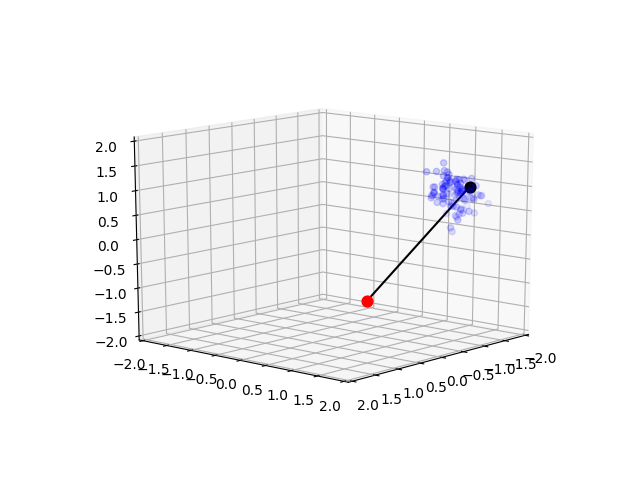

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-2, 2)

In [117]:
num_gen_states = 100
state = np.array([-0.00934646,  0.63374764, -1.1993216 ])
goal = np.array([-0.8914087,  1.8443041,  1.1627929])
state_in = torch.tensor(state, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)
goal_in = torch.tensor(goal, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)
z = torch.randn(state_in.size(0), latent_dim).to("cuda")
gen_target_states = netG_1(z, state_in, goal_in)
targets = gen_target_states.cpu().data.numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(state[0], state[1], state[2], s=60, c="red")
ax.scatter(goal[0], goal[1], goal[2], s=60, c="black")
ax.plot([state[0], goal[0]], [state[1], goal[1]], [state[2], goal[2]], c="black")
ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], c=[0,0,1,0.2])

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

black is the goal, red is current state - relatively reasonable!

In [118]:
np.linalg.norm(state-goal)

2.7969743740677706

In [119]:
avg = 0
for i in range(10):
    avg += np.linalg.norm(goal-targets[i,:])
    print(np.linalg.norm(goal-targets[i,:]))
avg /= 10

0.48190974381562557
0.3277733357562082
0.6777377725428257
0.28457476049663405
0.5564600198451671
0.6135075097333564
0.2746199092897888
0.17182920996428064
0.7610985747301763
0.2173658676282768


In [120]:
avg

0.43668767038023387

let's try visualising going backwards

<IPython.core.display.Javascript object>


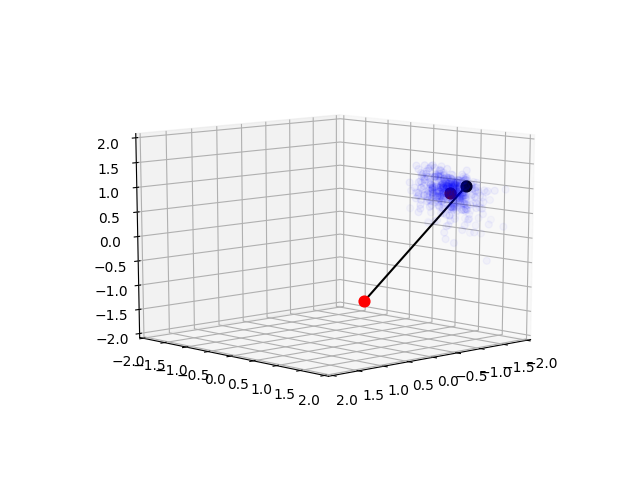

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-2, 2)

In [110]:
from sklearn.cluster import KMeans
state = np.array([-0.00934646,  0.63374764, -1.1993216 ])
goal = np.array([-0.8914087,  1.8443041,  1.1627929])
num_gen_states = 500
num_steps = 1
c_r = np.linspace(0, 1, num_steps+2)
colours = [[c_r[i+1], 0, 0, 1] for i in range(num_steps)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(state[0], state[1], state[2], s=60, c="red")
ax.scatter(goal[0], goal[1], goal[2], s=60, c="black")
ax.plot([state[0], goal[0]], [state[1], goal[1]], [state[2], goal[2]], c="black")

state_in = torch.tensor(state, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)
goal_in = torch.tensor(goal, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)

for ts in range(num_steps):
    z = torch.randn(state_in.size(0), latent_dim).to("cuda")
    gen_target_states = netG_1(z, state_in, goal_in)
    k_means = KMeans(n_clusters=1)
    k_means.fit(gen_target_states.cpu().data.numpy())
    goal = (k_means.cluster_centers_).reshape(-1)
    gen_states = gen_target_states.cpu().data.numpy()
    ax.scatter(goal[0], goal[1], goal[2], s=60, c=colours[ts])
    ax.scatter(gen_states[:,0], gen_states[:,1], gen_states[:,2], c=[0,0,1,0.05], s=25)
    goal_in = torch.tensor(goal, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)
    
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

<IPython.core.display.Javascript object>


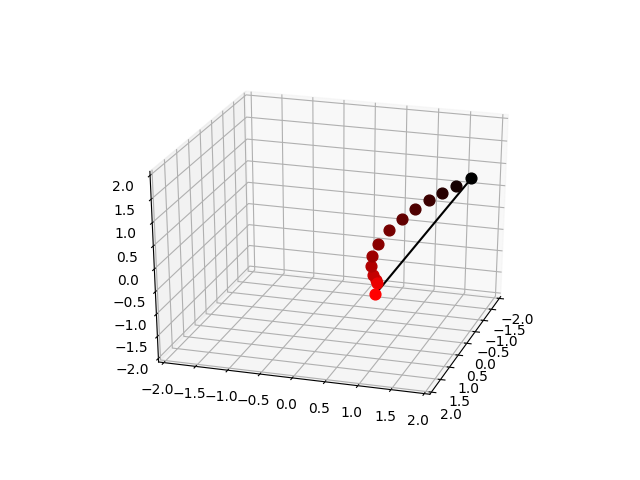

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(-2, 2)

In [115]:
from sklearn.cluster import KMeans
state = np.array([-0.00934646,  0.63374764, -1.1993216 ])
goal = np.array([-0.8914087,  1.8443041,  1.1627929])
num_gen_states = 500
num_steps = 12
c_r = np.linspace(0, 1, num_steps+2)
colours = [[c_r[i+1], 0, 0, 1] for i in range(num_steps)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(state[0], state[1], state[2], s=60, c="red")
ax.scatter(goal[0], goal[1], goal[2], s=60, c="black")
ax.plot([state[0], goal[0]], [state[1], goal[1]], [state[2], goal[2]], c="black")

state_in = torch.tensor(state, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)
goal_in = torch.tensor(goal, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)

for ts in range(num_steps):
    z = torch.randn(state_in.size(0), latent_dim).to("cuda")
    gen_target_states = netG_1(z, state_in, goal_in)
    k_means = KMeans(n_clusters=1)
    k_means.fit(gen_target_states.cpu().data.numpy())
    goal = (k_means.cluster_centers_).reshape(-1)
    gen_states = gen_target_states.cpu().data.numpy()
    ax.scatter(goal[0], goal[1], goal[2], s=60, c=colours[ts])
    #ax.scatter(gen_states[:,0], gen_states[:,1], gen_states[:,2], c=[0,0,1,0.05], s=25)
    goal_in = torch.tensor(goal, dtype=torch.float32, device="cuda").view(1,-1).repeat(num_gen_states, 1)
    
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

imperfect, but kind of works! Also lots of other ways you could think about this "backtracking" process - e.g. pick all that are within avg_empirical_dist +/- std_empirical_dist and then choose the one closest to the starting state (kind of cheating, but still)

possibly part of the issue why this doesn't look too good (it's not THAT bad though) is:
1. Training on random trajectories - there will be loads that do go all over the place before reaching a goal.
2. With random actions, it is possible to move a long way within $\tau=5$ moves
3. Obviously the GAN probably isn't perfect